**running time = 55 min** Intel i5-2450M 2500MHz / 4096Mb Memory / AMD Radeon HD 7600M

В файле problem_train.csv в каждой строке содержится информация об
объекте с уникальным идентификатором, заданным в столбце id.

В файле
problem_labels.csv для каждого id из файла problem_train.csv приведена
информация о принадлежности к 14 категориям. 

Цель задачи предсказать вероятности принадлежности к тому или иному классу по входным данным problem_test.csv

Для оценки качества полученного результата будет использоваться
метрика LogLoss. По каждой из 14 категорий метрика считается независимо,
затем берется среднее арифметическое значений метрик, полученных для
категорий.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import log_loss
import time

# Предварительный анализ данных

In [34]:
data = pd.read_csv('problem_train.csv', delimiter=',',low_memory=False)
data_predict = pd.read_csv('problem_test.csv', delimiter=',',low_memory=False)
labels = pd.read_csv('problem_labels.csv', delimiter=',')

In [35]:
display(data.head())
display(labels.head())
display(data_predict.head())

,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,11193,a,NaN,NaN,0.025449,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,11382,a,NaN,NaN,0.031297,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,NaN,NaN,NaN,NaN
2,16531,a,NaN,NaN,0.024475,NaN,NaN,0.342105,NaN,NaN,...,NaN,NaN,a,NaN,a,NaN,b,NaN,NaN,NaN
3,1896,a,NaN,NaN,0.041694,NaN,NaN,0.447368,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,NaN
4,18262,c,NaN,NaN,0.038120,NaN,NaN,0.315789,NaN,NaN,...,NaN,NaN,b,NaN,a,NaN,a,NaN,NaN,NaN


,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,11193,1,1,0,0,0,0,0,0,0,1,1,0,0,0
1,11382,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,16531,0,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1896,0,0,0,1,0,0,0,0,0,1,0,1,0,0
4,18262,0,0,0,1,1,0,0,0,0,0,1,1,1,0


,id,release,n_0000,n_0001,n_0002,n_0003,n_0004,n_0005,n_0006,n_0007,...,c_1368,c_1369,c_1370,c_1371,c_1372,c_1373,c_1374,c_1375,c_1376,c_1377
0,7957,a,NaN,NaN,0.029890,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,q,NaN,NaN,NaN
1,693,c,NaN,0.452381,0.032164,NaN,NaN,0.421053,0.0,NaN,...,NaN,NaN,NaN,NaN,a,NaN,x,NaN,NaN,NaN
2,15558,c,NaN,0.547619,0.049166,NaN,NaN,0.500000,0.2,NaN,...,NaN,NaN,NaN,NaN,a,e,b,NaN,NaN,NaN
3,15614,a,NaN,NaN,0.048733,NaN,NaN,0.394737,NaN,NaN,...,NaN,NaN,NaN,NaN,b,NaN,NaN,NaN,NaN,NaN
4,8149,b,NaN,NaN,0.049924,NaN,NaN,0.368421,NaN,NaN,...,NaN,NaN,NaN,NaN,a,NaN,NaN,NaN,NaN,b


Text(0.5,0,'Label')

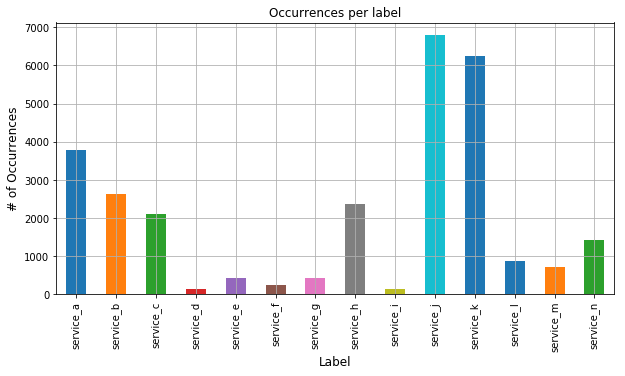

In [5]:
# Посмотрим на распределение количества меток по всем лейблам
# Видим, что некоторые лейблы встречаются чаще других
counts = list()
for col in labels.columns[1:]:
    counts.append((col,labels[col].sum()))
cat_counts = pd.DataFrame(counts, columns=['category', 'count'])

cat_counts.plot(x='category', y='count', kind='bar', legend=False, grid=True, figsize=(10, 5))
plt.title("Occurrences per label")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)

In [6]:
# Посмотрим соотношение типов в наших признаках, видим что категориальных достаточно много (1025) и после кодирования получим
# довольно разреженную матрицу
types = data.dtypes.values
unique, counts = np.unique(types, return_counts=True)
print(dict(zip(unique, counts)))

{dtype('int64'): 9, dtype('float64'): 345, dtype('O'): 1025}


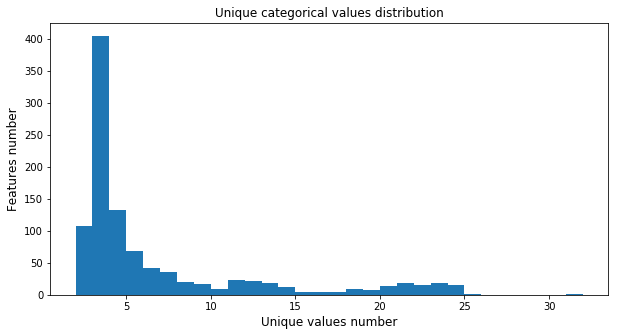

In [7]:
# Посмотрим на соотношение категорильных признаков по количеству уникальных значений 
# Больше всего признаков с 3 значениями, например a,b,c.
unique_count = list()
o_idx = np.where(types==np.dtype('O'))[0]
for col_idx in o_idx:
    s = data.iloc[:,col_idx]
    unique_count.append(s.unique().shape[0])
plt.figure(figsize = (10,5))
plt.hist(unique_count,bins=30)
plt.title('Unique categorical values distribution')
plt.ylabel('Features number', fontsize=12)
plt.xlabel('Unique values number', fontsize=12)
plt.show()

# Предобработка данных

In [8]:
# Функция для One-hot-encoding преобразования категориальных признаков
def encode_data(data):
    encoded_data = data['id'] #будем присоедниять к нему новые столбцы в циклке
    data = data.drop('id',axis=1)
    dtypes = data.dtypes
    
    sum0 = 0 #для подсчета количества сгенерированных бинарных признаков
    for i, col in enumerate(data.columns):
        if(dtypes[i]==np.dtype('O')):
            dummy = pd.get_dummies(data[col])
            # например признак feature разбивается на 3 бинарных feature_a, feature_b, feature_c
            dummy.columns = ['_'.join([col,s]) for s in dummy.columns.values]
            encoded_data = pd.concat([encoded_data,dummy],axis=1)
            sum0 += dummy.shape[1]
        else:
            #если признак не категория - просто присоединяем его.
            encoded_data = pd.concat([encoded_data,data[col]],axis=1)
    
    print('encoded columns ', sum0)
    print(encoded_data.shape)
    return encoded_data

In [9]:
encoded_data = encode_data(data)
# удаляем признаки у которых все значения нули
encoded_data = encoded_data.dropna(axis=1, how='all')
print(encoded_data.shape) # удалилось 30 пустых признаков

encoded columns  5510
(8000, 5864)
(8000, 5834)


In [10]:
# То же самое для данных, на которых нужно дать предсказания
encoded_data_predict = encode_data(data_predict)
encoded_data_predict = encoded_data_predict.dropna(axis=1, how='all')
print(encoded_data_predict.shape) # удалилось 179 пустых признаков

encoded columns  4119
(2000, 4585)
(2000, 4406)


In [11]:
# В тестовой выборке могут быть признаки, которых нету в новой и наоборот. Проверим это
columns = encoded_data.columns.values
columns_predict = encoded_data_predict.columns.values
# Признаки которые есть в тренировочной но нет в новой
useless_columns = [c for c in columns if c not in columns_predict]
print('useless_columns ', len(useless_columns))
# Признаки которые есть в новой но нет в тренировочной
new_columns = [c for c in columns_predict if c not in columns]
print('new_columns ', len(new_columns))

useless_columns  1592
new_columns  164


Я решил удалить из тренировочной выборки признаки useless_columns чтобы зря не обучаться под них, т.к. в новой выборке их не будет. Понятно, что реальном мире не имеет смысла это делать (возможно заменять значения недостающих признаков на 0).
Аналогично поступаем с новой выборкой и new_columns, т.к. в тренировочной выборке нет данных чтобы учиться под эти признаки

In [12]:
encoded_data = encoded_data.drop(useless_columns,axis=1)
encoded_data_predict = encoded_data_predict.drop(new_columns,axis=1)
print(encoded_data.shape, encoded_data_predict.shape)
# Получили выборки с одинаковыми признаками.

(8000, 4242) (2000, 4242)


In [13]:
# удаляем столбец с айдишниками
encoded_data = encoded_data.drop('id',axis=1)
labels = labels.drop('id',axis=1)

# Выбор наилучшей модели

In [14]:
# в эту таблицу будем писать logloss для каждой из категорий
losses = pd.DataFrame(index=labels.columns)

In [15]:
def get_score(label,clf, X):
    y = labels[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

    clf.fit(X_train,y_train)
    print('.',end='') #'индикатор загрузки'
    return log_loss(y_test, clf.predict_proba(X_test))
    
def get_all_scores(clf_name,clf,X):
    losses[clf_name] = np.nan #добавляем пустую колонку
    for label in labels.columns:
        losses[clf_name].loc[label]= get_score(label, clf, X)  #наполняем колонку потерями для каждой категории
# losses-итоговая таблица с потерями, смотрите ее ниже

Пробуем разные варианты классификатора

In [16]:
%%time
# заполняем пропуски нулями, при заполнении средними качество получилось хуже
X = encoded_data.fillna(0)
get_all_scores('lr l2', LogisticRegression(penalty ='l2'), X)

..............Wall time: 1min 55s


In [17]:
%%time
X = encoded_data.fillna(0)
get_all_scores('lr l1', LogisticRegression(penalty ='l1'), X)

..............Wall time: 34.3 s


In [18]:
%%time
X = encoded_data.dropna(axis=1)
get_all_scores('lr l2 dropna', LogisticRegression(penalty ='l2'), X)

..............Wall time: 28.6 s


In [19]:
%%time
X = encoded_data.dropna(axis=1)
get_all_scores('lr l1 dropna', LogisticRegression(penalty ='l1'), X)

..............Wall time: 27.3 s


# Поиск оптимальных гиперпараметров

In [20]:
# улучшим LogisticRegression(penalty ='l1'), она показывает хорошие результаты на выборке с удаленными пропусками. (см таблицу)
def find_opt(col, clf, coef, _range):
    loss_list = list()
    for k in _range:
        clf.set_params(**{coef:k})
        loss =get_score(col, clf, X)
        loss_list.append([k,loss])
    loss_list = np.array(loss_list)
    loss_list[loss_list[:,1].argmin()]
    par_min = loss_list[loss_list[:,1].argmin()]
    print('min coord ', par_min)
    plt.plot(loss_list[:,0],loss_list[:,1])
    plt.scatter(par_min[0],par_min[1],c='r')
    plt.title('logloss vs hyperparameter')
    plt.ylabel('logloss', fontsize=12)
    plt.xlabel(coef, fontsize=12)
    plt.show()
    return par_min

service_a..................................................min coord  [0.15816327 0.35487073]


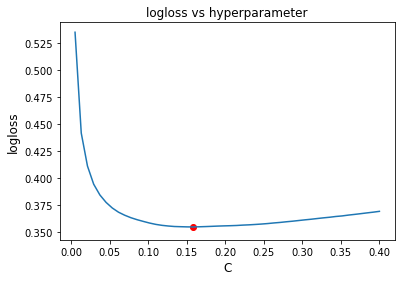

service_b..................................................min coord  [0.08561224 0.49124592]


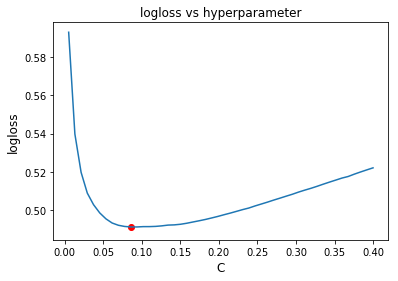

service_c..................................................min coord  [0.15010204 0.49113198]


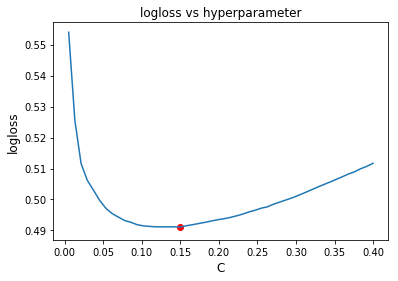

service_d..................................................min coord  [0.25489796 0.03226327]


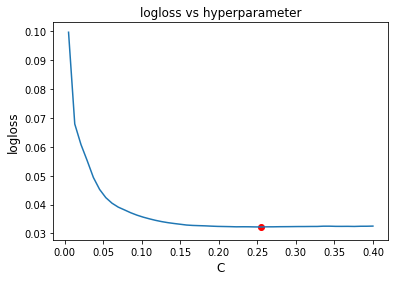

service_e..................................................min coord  [0.15010204 0.16809282]


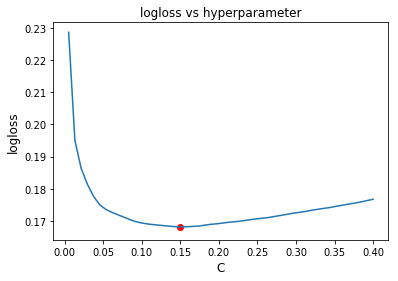

service_f..................................................min coord  [0.13397959 0.07002513]


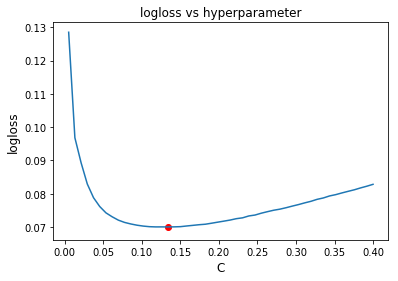

service_g..................................................min coord  [0.11785714 0.1688282 ]


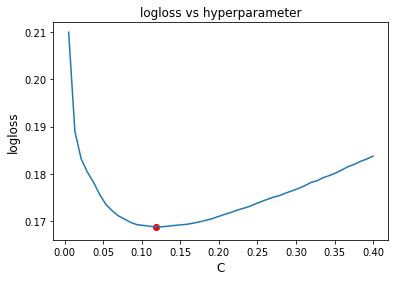

service_h..................................................min coord  [0.12591837 0.43974175]


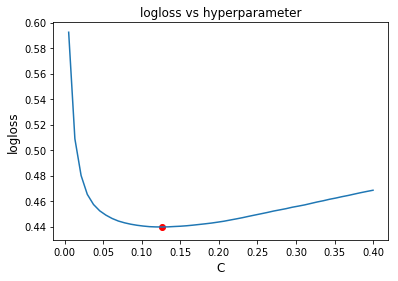

service_i..................................................min coord  [0.31938776 0.04683675]


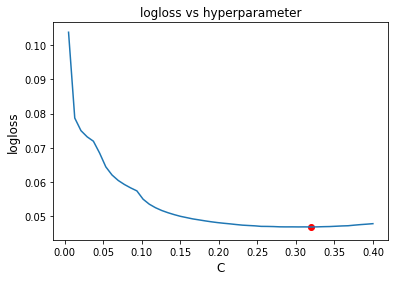

service_j..................................................min coord  [0.06142857 0.36307184]


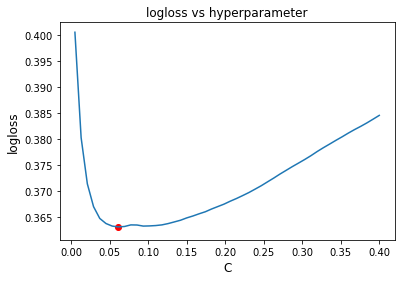

service_k..................................................min coord  [0.0694898 0.4591354]


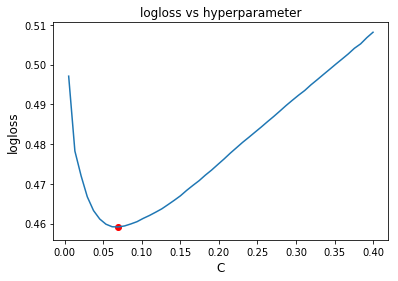

service_l..................................................min coord  [0.21459184 0.09207542]


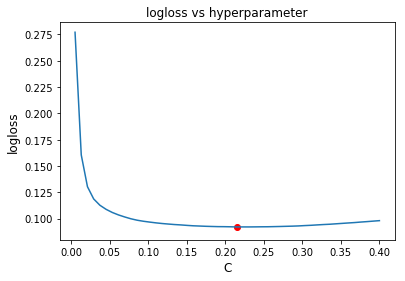

service_m..................................................min coord  [0.25489796 0.09044375]


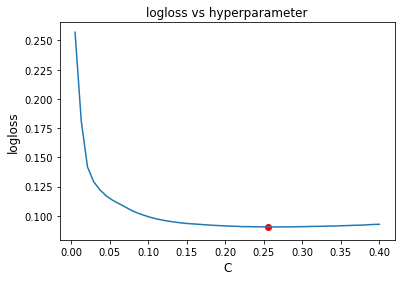

service_n..................................................min coord  [0.09367347 0.35124896]


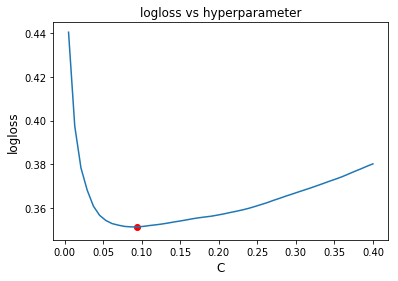

Wall time: 11min 50s


In [21]:
%%time
X = encoded_data.dropna(axis=1)
best_C = list()
for l in labels:
    print(l,end='')
    C = find_opt(l,LogisticRegression(penalty ='l1'),
            'C', np.linspace(0.005,0.4,num=50))
    best_C.append(C)

In [22]:
# получили для каждой категории индивидуальный гиперпараметр меры регуляризации. Чем меньше С тем сильнее регуляризация.
best_C = np.array(best_C)

In [23]:
def get_score(label,clf, X):
    y = labels[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

    clf.fit(X_train,y_train)
    print('.',end='')
    return log_loss(y_test, clf.predict_proba(X_test))
    
# Немного изменим функцию для банча классификаторров
def get_all_scores_div(clf_name,clf,X):
    losses[clf_name] = np.nan
    for i,label in enumerate(labels.columns):
        losses[clf_name].loc[label]= get_score(label, clf.set_params(**{'C':best_C[i,0]}), X)
        
get_all_scores_div('lr division',LogisticRegression(penalty ='l1'),X)
# Такиим образом в таблицу (см ниже, столбик lr division) записываем лог.потери,
# используем индивидуальный параметр из best_C для каждой категории

..............

In [24]:
%%time
# игрался с разными параметрами
X = encoded_data.dropna(axis=1)
get_all_scores('lr l1 saga', LogisticRegression(penalty ='l1', solver='saga'),X)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


..............Wall time: 20min 7s


In [25]:
%%time
X = encoded_data.dropna(axis=1)
get_all_scores('lr l1 saga c=0.1', LogisticRegression(penalty ='l1', solver='saga',C=0.1),X)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


..............Wall time: 14min 43s


## Итоговая таблица потерь

In [26]:
#  Сводка всех logloss по разным классификаторам
# В последних двух колонках лучший классификатор и соответсвующая ему ошибка
p = pd.concat([losses,losses.idxmin(axis=1),losses.min(axis=1)],axis=1)
val = p.columns.values
val[-2:]= ['best clf','best loss']
p.columns = val
p

,lr l2,lr l1,lr l2 dropna,lr l1 dropna,lr division,lr l1 saga,lr l1 saga c=0.1,best clf,best loss
service_a,0.572793,0.475997,0.515851,0.442159,0.354927,0.395673,0.406100,lr division,0.354927
service_b,0.714035,0.635842,0.677184,0.609901,0.491226,0.500063,0.506083,lr division,0.491226
service_c,0.672286,0.608682,0.643692,0.585418,0.491264,0.490637,0.496432,lr l1 saga,0.490637
service_d,0.053221,0.043117,0.045438,0.037748,0.032312,0.048609,0.055134,lr division,0.032312
service_e,0.307857,0.245056,0.258544,0.217114,0.168113,0.173138,0.178364,lr division,0.168113
service_f,0.156956,0.133065,0.123403,0.107657,0.070000,0.102281,0.106618,lr division,0.070000
service_g,0.306713,0.250509,0.265472,0.230107,0.168808,0.172512,0.177533,lr division,0.168808
service_h,0.652107,0.577333,0.604006,0.542118,0.439737,0.467382,0.477108,lr division,0.439737
service_i,0.086190,0.067713,0.066342,0.057786,0.046728,0.068166,0.071197,lr division,0.046728
service_j,0.544180,0.481871,0.507284,0.449367,0.363034,0.360327,0.362054,lr l1 saga,0.360327


# Построение предсказаний

### Видно, что solver='saga' по некоторым категориям выбивается в лучшие. Были проверены и другие классификаторы: SVC, GaussianNB, SVC(kernel="linear") показывают более менее хорошие результаты. Но вычисления на ноутбуке занимают много времени, поэтому возьмем все классификаторы LogisticRegression с подобранными под каждую категорию коэфф. регуляризации.

In [27]:
# Мы в тренировочной выборке удаляли столбцы с нулями, так что удалим лишние признаки из новой выборки
columns = X.columns.values
columns_predict = encoded_data_predict.columns.values
# Признаки которые есть в тренировочной но нет в новой
useless_columns = [c for c in columns if c not in columns_predict]
print('useless_columns ', len(useless_columns))
# Признаки которые есть в новой но нет в тренировочной
new_columns = [c for c in columns_predict if c not in columns]
print('new_columns ', len(new_columns))

useless_columns  0
new_columns  272


In [28]:
encoded_data_predict = encoded_data_predict.drop(new_columns,axis=1)

In [29]:
def fit_train(label,clf, X):
    y = labels[label]
    clf.fit(X,y)
    return clf.predict_proba(encoded_data_predict)[:,1]
   
# инициализируем y_predicted, будем приписывать справа вероятности принадлежности к категории
y_predicted = pd.read_csv('problem_test.csv', delimiter=',',low_memory=False)['id']

for i,label in enumerate(labels.columns):
    clf = LogisticRegression(penalty ='l1')
    clf.set_params(**{'C':best_C[i,0]})
    ser= pd.Series(fit_train(label, clf, X))
    y_predicted = pd.concat([y_predicted,ser],axis=1)    

# переименуем колонки
y_predicted.columns = np.append(['id'],labels.columns.values)
y_predicted.head()

,id,service_a,service_b,service_c,service_d,service_e,service_f,service_g,service_h,service_i,service_j,service_k,service_l,service_m,service_n
0,7957,0.996111,0.584657,0.238870,0.001388,0.019783,0.000574,0.009386,0.058066,0.002894,0.882662,0.851720,0.000678,0.000932,0.088832
1,693,0.019739,0.050529,0.012728,0.015187,0.008748,0.000433,0.001483,0.070807,0.000115,0.921910,0.863017,0.002940,0.002128,0.058844
2,15558,0.487722,0.675694,0.389685,0.000448,0.036536,0.001525,0.140556,0.147492,0.007126,0.734113,0.720647,0.002229,0.000555,0.209823
3,15614,0.215258,0.138189,0.153444,0.000974,0.015145,0.000716,0.063738,0.264315,0.004828,0.760448,0.713687,0.005675,0.002437,0.248097
4,8149,0.950153,0.732400,0.370678,0.000007,0.012006,0.002173,0.090641,0.189302,0.007360,0.632956,0.445838,0.004773,0.000943,0.003766


In [30]:
y_predicted.to_csv('problem_test_predicted_proba.csv', sep=',',index=False)

Спасибо за внимание